# MixSig
## Option 1
Create a model that reads a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Option 2
Create a model that reads a sequence of numbers and classifies the last number in the sequence based on the previous numbers in the sequence.

## How this project is useful
 1. full control over dataset
 2. infinite dataset
 3. can study all three RNN base problems (classification, prediction, forcasting).
 

## Project Steps
 1. create dataset
 2. create network
 3. train network
 4. test network

## TODO
 - [+] create single signal generator class - A single standalone wave.
 - [+] create mixed signal generator class - Choose from one wave per timestamp.
 - [ ] create multi signal generator class - Superposition of multiple waves.
 - [+] create signal noise functions (Gaussian, etc.)
 - [+] create timestep noise functions 
 - [+] add legends to plots.
 - [ ] during training, save outlier X, y train sets to file for further analysis.
 - [+] save configuration of mixed signal properties as json.
 - [ ] make plots of the mixed signal with colors mapped to hidden layers, lstm states, etc.
 - [ ] unit tests with pytest
 - [ ] unit tests with pytest - args
 - [ ] unit tests with pytest - kwargs
 - [ ] unit tests with pytest - random generators
 - [+] create startup.py to handle project directories and other goodies.
 - [+] fix savefig clipping the bottoms of our figures.

## Data generator parameters to test
 1. All 4 wave variables
  - amplitude
  - frequency (period)
  - offset
  - phase
 2. sequence length
 3. signal noise
 4. timestep noise
 5. number of signals
 6. types of signals (single, mixed, multi)

## Model hyperparameters to test
 - `n_timestamps`number of timestamps
 - `window_size` number of timesteps in sub-sequence window
 - `n_neurons` number of neurons per LSTM
 - number of LSTM recurrent cells
 - number of LSTM layers
 - `n_epochs` number of epochs
 - `batch_size`
 - `window_type` Sliding or Boxcar?
 - `stateful` True or False?

## Questions to answer
 Q: What would a batch look like?
 
 Q: How many LSTM layers do we need? nodes per LSTM layer?
 
 Q: Can we learn if our timestamps are not uniformly spaced.
 
 Q: Should we make the LSTM layers stateful?
 
 Q: Should we use sliding window or boxcar sequences?
 
 Q: For stateful LSTM's must we call `model.reset_states()` after any `model.evaluate()` and/or `model.predict()` calls? 
 
 A: **YES** Ref: Greenlee's book on LSTM's. p.49

## Notes

In [1]:
import os
import sys
import json
import h5py
import itertools
import numpy as np
import pandas as pd
from pandas.plotting import table
from random import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

# from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Masking
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

from mixsig.mixed import MixedSignal
from mixsig.plot_utils import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
sys.path.append('/home/maddoxw/git/PhasedLSTM-Keras')
from phased_lstm_keras.PhasedLSTM import PLSTM

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [4]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)

def plot_stats(csv_filename, columns=['total_reward'], **kwargs):
    """Plot specified columns from CSV file."""
    df_stats = pd.read_csv(csv_filename)
    df_stats[columns].plot(**kwargs)

# Ref http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/
def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / (1 + span)
    s = np.zeros((N,))
    b = np.zeros((N,))
    s[0] = x[0]
    for i in range(1, N):
        s[i] = alpha * x[i] + (1 - alpha) * (s[i-1] + b[i-1])
        b[i] = beta * (s[i] - s[i-1]) + (1 - beta) * b[i-1]
    return s

def reversed_recombined_holt_winters(x, span=15, beta=0.3):
    # take EWMA in both directions with a smaller span term
    fwd = holt_winters_second_order_ewma(x, span, beta)
    bwd = holt_winters_second_order_ewma(x[::-1], span, beta)
    c = np.vstack((fwd, bwd[::-1])) # lump fwd and bwd together
    c = np.mean(c, axis=0) # average
    return c

def save_rnn_layers(hidden_layers, output_layers):
    for i, layer in hidden_layers.items():
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_output'), hidden_layers[i]['output'])
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_state'), hidden_layers[i]['state'])
#     np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_2_output'), hidden_layers['2']['output'])
#     np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_2_state'), hidden_layers['2']['state'])
    np.save(os.path.join(vsig.out_dir, 'valid_output_layer'), output_layers)
    
def save_mlp_layers(hidden_layers, output_layers):
    for i, layer in hidden_layers.items():
        np.save(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + i + '_output'), layer)
    np.save(os.path.join(vsig.out_dir, 'valid_output_layer'), output_layers)
    
def glance_at_tensor(tensor):
    if len(tensor.shape) == 3:
        print(tensor[:10, 0, 0])
        print(tensor[0, :10, 0])
        print(tensor[0, 0, :10])
        print('')
        print(tensor[-10:, -1, -1])
        print(tensor[-1, -10:, -1])
        print(tensor[-1, -1, -10:])
    elif len(tensor.shape) == 4:
        print(tensor[:10, 0, 0, 0])
        print(tensor[0, :10, 0, 0])
        print(tensor[0, 0, :10, 0])
        print(tensor[0, 0, 0, :10])
        print('')
        print(tensor[-10:, -1, -1, -1])
        print(tensor[-1, -10:, -1, -1])
        print(tensor[-1, -1, -10:, -1])
        print(tensor[-1, -1, -1, -10:])

## Build a signal generator

The signal generator builds waves using the standard form:

$$x(t) = A\sin\left(2\pi f t + \phi\right) + h$$

where $A$ is the amplitude (vertical scale), $f$ is the frequency (horizontal scale), $\phi$ is the phase (horizontal offset) and $h$ is the height (vertical offset). This give us fine grained control over how we construct our waves.

In [17]:
# start off with simplest case for proof of concept
wave1_coeffs = {
    'amplitude': {'mean': 1, 'delta': 0.1}, 
    'frequency': {'mean': 1, 'delta': 0},
    'offset': {'mean': 0.2, 'delta': 0.1}, 
    'phase': {'mean': 0, 'delta': 0},
    'name': 'A',
    'color': '#0000ff'
}
wave2_coeffs = {
    'amplitude': {'mean': 1, 'delta': 0.1}, 
    'frequency': {'mean': 1, 'delta': 0},
    'offset': {'mean': 0, 'delta': 0.1}, 
    'phase': {'mean': 0, 'delta': 0},
    'name': 'B',
    'color': '#ff0000',
#     'time': {'t_min': 0, 't_max': 5, 'n_timestamps': 601, 'noise_type': 'pareto', 'pareto_shape': 1.3},
}
wave3_coeffs = {
    'amplitude': {'mean': 1, 'delta': 0.1}, 
    'frequency': {'mean': 1, 'delta': 0},
    'offset': {'mean': -0.2, 'delta': 0.1}, 
    'phase': {'mean': 0, 'delta': 0},
    'name': 'C',
    'color': '#00ff00'
}

sigs_coeffs = [wave1_coeffs, wave2_coeffs, wave3_coeffs]

msig_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0.5}, 
    'frequency': {'mean': 2.0, 'delta': 1.0}, 
    'offset': {'mean': 0, 'delta': 1},
    'phase': {'mean': 0, 'delta': 1}, 
    'time': {'t_min': 0, 't_max': 4, 'n_timestamps': 1500, 'delta': 0}
}

batch_size = 32
window_size = 100
window_type = 'sliding'
network_type = 'RNN'
sequence_code = 'xw1_xc'
n_groups = 5

msig = MixedSignal(
    sigs_coeffs, 
    msig_coeffs,
#     batch_size=batch_size,
    window_size=window_size, 
    window_type=window_type, 
    network_type=network_type,
    sequence_code=sequence_code,
    n_groups=n_groups
)

msig.generate()
n_classes = msig.n_classes
print(msig.X.shape, msig.y.shape)

print(msig.mixed_signal.shape)
print(msig.one_hots.shape)
print(msig.labels.shape)
print(msig.n_timestamps)
print(msig.n_samples)

(1401, 100, 1) (1401, 3)
(1500,)
(1500, 3)
(1500,)
1500
1401


In [ ]:
# df = pd.DataFrame(np.vstack((msig.waves, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
waves = np.array([sig.generate(msig.timestamps) for sig in msig.waves])
df = pd.DataFrame(np.vstack((msig.timestamps, waves, msig.mixed_signal)).T, columns=['time', 'A', 'B', 'C', 'Mixed'])
df[:10].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

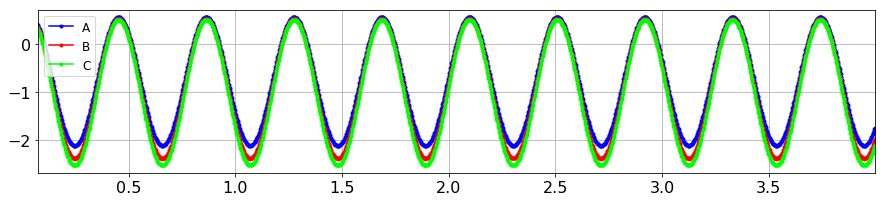

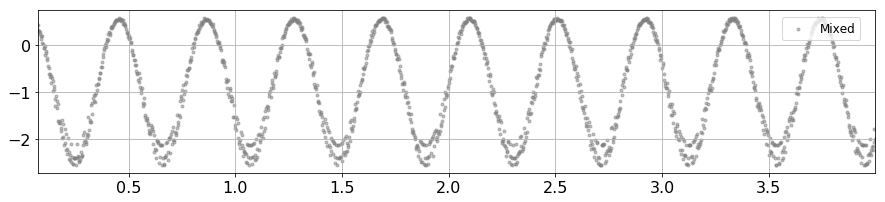

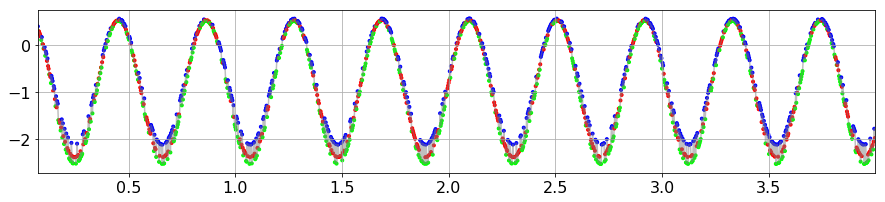

In [6]:
msig.save_config()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
legend_labels = []
for wave in msig.waves:
    ax.plot(wave.timestamps, wave.sample, marker='.', color=wave.color)
    legend_labels.append(wave.name)
ax.set_xlim((msig.t_min, msig.t_max))
plt.grid(True)
ax.legend(legend_labels)
plt.savefig(os.path.join(msig.out_dir, 'all_waves_with_truth.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.scatter(msig.timestamps, msig.mixed_signal, color='grey', marker='.', alpha=0.5)
ax.set_xlim((msig.t_min, msig.t_max))
plt.grid(True)
ax.legend([msig.name], loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.savefig(os.path.join(msig.out_dir, 'mixed_signal.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.5)
y_test_colors = np.hstack([msig.waves[i].color for i in msig.labels])
ax.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=y_test_colors)
ax.set_xlim((msig.t_min, msig.t_max))
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mixed_signal_with_truth.png'))
plt.show()

# Playground

In [6]:
n_features = 1
n_neurons = 32
kernel_size = 3
stateful = False

In [ ]:
# input_shape = (msig.window_size, msig.n_features)
input_shape = msig.input_shape
x = Input(shape=input_shape)
h1 = Dense(n_neurons, activation='relu')(x)
h2 = Dense(n_neurons, activation='relu')(h1)
z = Dense(msig.n_classes, activation='softmax')(h2)
model = Model(inputs=[x], outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [8]:
input_shape = msig.X.shape
print(input_shape)
model_kwargs = dict(kernel_size=kernel_size, padding='causal', activation='relu')
model = Sequential()
model.add(Conv1D(n_neurons, dilation_rate=1, input_shape=input_shape, **model_kwargs))
for d in [2, 4, 8, 16]:
    model.add(Conv1D(n_neurons, dilation_rate=d, **model_kwargs))
# model.add(Conv1D(n_neurons, kernel_size=5, padding='causal', dilation_rate=4, activation='relu'))
# model.add(Conv1D(n_neurons, kernel_size=5, padding='causal', dilation_rate=8, activation='relu'))
# model.add(Conv1D(n_neurons, kernel_size=5, padding='causal', dilation_rate=16, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

(1472, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1472, 32)          128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1472, 32)          3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1472, 32)          3104      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1472, 32)          3104      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1472, 32)          3104      
_________________________________________________________________
dense_1 (Dense)              (None, 1472, 3)           99        
Total params: 12,643
Trainable params: 12,643
Non-trainable params: 0
______________________________________________________________

In [ ]:
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(n_neurons, input_shape=(msig.window_size, 1), return_sequences=True))
# model.add(LSTM(n_neurons, input_shape=self.input_shape, return_sequences=False, dropout=0.5))
# model.add(LSTM(n_neurons, input_shape=(2, 1)))
# model.add(LSTM(n_neurons, input_shape=(window_size, 2)))
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, window_size, 1), stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(window_size, 1, 1), stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(window_size, 1, 1), stateful=stateful))
model.add(LSTM(n_neurons, stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons))
# for _ in range(n_layers):
#     model.add(LSTM(n_neurons, stateful=stateful, return_sequences=True))
# model.add(LSTM(n_neurons, stateful=stateful))
# model.add(Dense(n_classes, activation='softmax'))
# model.add(Dropout(0.5))
# model.add(Reshape((n_neurons, n_classes, 1)))
model.add(TimeDistributed(Dense(n_classes, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [7]:
x = Input(batch_shape=(batch_size, window_size, n_features))
z1 = LSTM(n_neurons, return_sequences=True, stateful=stateful)(x)
z2 = LSTM(n_neurons, return_sequences=False, stateful=stateful)(z1)
z = Dense(n_classes, activation='softmax')(z2)
# z = TimeDistributed(Dense(n_classes, activation='softmax'))(z2)

model = Model(inputs=[x], outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (32, 100, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (32, 100, 32)             4352      
_________________________________________________________________
lstm_2 (LSTM)                (32, 32)                  8320      
_________________________________________________________________
dense_1 (Dense)              (32, 3)                   99        
Total params: 12,771
Trainable params: 12,771
Non-trainable params: 0
_________________________________________________________________


In [15]:
x_test, y_test = msig.generate()
x_test.shape, y_test.shape

((1376, 100, 1), (1376, 3))

In [16]:
model.evaluate(x_test[1:], y_test[1:])

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 1375 samples

In [ ]:
x = Input(batch_shape=(batch_size, window_size, 1))
z1 = PLSTM(n_neurons, return_sequences=True, implementation=2)(x)
z2 = PLSTM(n_neurons, return_sequences=True, implementation=2)(z1)
z = Dense(n_classes, activation='softmax')(z2)
model = Model(inputs=[x], outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [9]:
model_config_filename = os.path.join(msig.out_dir, 'model_config.json')
model_summary_filename = os.path.join(msig.out_dir, 'model_plot.png')
with open(model_config_filename, 'w') as ofs:
    json.dump(json.loads(model.to_json()), ofs, indent=4)
plot_model(model, to_file=model_summary_filename, show_shapes=True, show_layer_names=True)

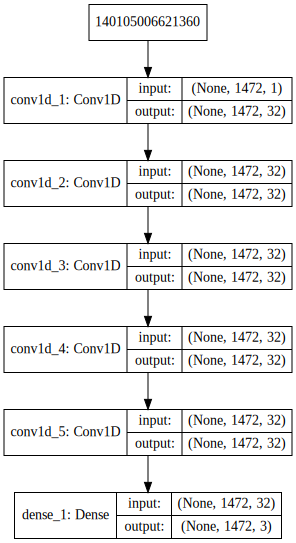

In [32]:

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
x_valid, y_valid, *_ = msig.generate_samples(32)
print(x_valid.shape)
print(y_valid.shape)

(32, 1472, 1)
(32, 1472, 3)


# RNN Training

In [28]:
n_samples_train = 256
n_samples_valid = 128
epochs = 100
dump_every = 1
status_update_every = 50
# train_steps = msig.n_samples * n_samples_train // batch_size
# test_steps = msig.n_samples * n_samples_test // batch_size

csvlogger = CSVLogger(msig.training_stats_filename, separator=',', append=True)
checkpointer = ModelCheckpoint(msig.model_weights_filename, save_best_only=True, verbose=1)

x_test, y_test = msig.generate_samples(1)
test_dict = {
    'sequence_type': msig.sequence_type,
    'window_type': msig.window_type,
    'window_size': msig.window_size,
    'class_colors': np.hstack([wave.color for wave in msig.waves]),
    'timestamps': msig.timestamps,
    'X': x_test, 
    'y': y_test, 
    'y_hat': [],
    'epoch': [], 
    'score': [],
}

x_valid, y_valid, *_ = msig.generate_samples(n_samples_valid)

for i in range(epochs):
    x_train, y_train, *_ = msig.generate_samples(n_samples_train)
    model.fit(
        x_train, y_train,
        epochs=1, 
        validation_data=(x_valid, y_valid),
        batch_size=batch_size,
        verbose=1, 
        callbacks=[
            csvlogger,
            checkpointer
        ],
    )
    if stateful:
        model.reset_states()

    if (i + 1) % dump_every == 0:     
        test_dict['epoch'].append(i + 1)
        score = model.evaluate(test_dict['X'], test_dict['y'], batch_size=batch_size)
        if stateful:
            model.reset_states()
        test_dict['score'].append(score)

        y_hat = model.predict(test_dict['X'], batch_size=batch_size)
        if stateful:
            model.reset_states()
        test_dict['y_hat'].append(y_hat)

    if (i + 1) % status_update_every == 0:
        print('#' * 50)
        print(f'Epoch: {(i + 1)}/{epochs}')
        print('#' * 50)
        model.save(msig.model_filename)


Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.5389 - acc: 0.7604 - val_loss: 0.4553 - val_acc: 0.8031

Epoch 00001: val_loss improved from inf to 0.45531, saving model to /home/maddoxw/PycharmProjects/MixSig/out/2018_0711_0237/model_weights.h5
1/1 [==============================] - 0s 5ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4355 - acc: 0.8118 - val_loss: 0.4593 - val_acc: 0.7995

Epoch 00001: val_loss did not improve from 0.45531
1/1 [==============================] - 0s 5ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4893 - acc: 0.7836 - val_loss: 0.4969 - val_acc: 0.7800

Epoch 00001: val_loss did not improve from 0.45531
1/1 [==============================] - 0s 6ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [=========

128/128 [==============================] - 1s 8ms/step - loss: 0.4535 - acc: 0.8025 - val_loss: 0.4483 - val_acc: 0.8066

Epoch 00001: val_loss did not improve from 0.44070
1/1 [==============================] - 0s 6ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4443 - acc: 0.8051 - val_loss: 0.4718 - val_acc: 0.7937

Epoch 00001: val_loss did not improve from 0.44070
1/1 [==============================] - 0s 7ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 8ms/step - loss: 0.4698 - acc: 0.7933 - val_loss: 0.4713 - val_acc: 0.7937

Epoch 00001: val_loss did not improve from 0.44070
1/1 [==============================] - 0s 6ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4602 - acc: 0.7995 - val_loss: 0.4372 - val_acc: 0.8119

Epoch 00001: val_loss improved from 0.440

Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 8ms/step - loss: 0.4254 - acc: 0.8169 - val_loss: 0.4512 - val_acc: 0.8041

Epoch 00001: val_loss did not improve from 0.42663
1/1 [==============================] - 0s 7ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4527 - acc: 0.8036 - val_loss: 0.4400 - val_acc: 0.8104

Epoch 00001: val_loss did not improve from 0.42663
1/1 [==============================] - 0s 6ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 8ms/step - loss: 0.4574 - acc: 0.7987 - val_loss: 0.4385 - val_acc: 0.8107

Epoch 00001: val_loss did not improve from 0.42663
1/1 [==============================] - 0s 6ms/step
Train on 128 samples, validate on 64 samples
Epoch 1/1
128/128 [==============================] - 1s 7ms/step - loss: 0.4577 - acc: 0.8030 - val_loss: 0.4431 - val

In [ ]:
n_generations = 50
n_epochs = 1
validate_every = 1
save_every = 50

model_weights_filename = os.path.join(msig.out_dir, 'model_weights.h5')
training_stats_filename = os.path.join(msig.out_dir, 'training_stats.csv')
stats = {'gen': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
x_val, y_val = vsig.generate()
n_sequences = msig.n_samples
# n_sequences = msig.window_size
o_or_s = {0: 'output', 1: 'state'}

# hidden_layers = {
#     '1': {
#         'output': np.zeros((n_generations, n_sequences, n_neurons)), 
#         'state': np.zeros((n_generations, n_sequences, n_neurons))
#     },
#     '2': {
#         'output': np.zeros((n_generations, n_sequences, n_neurons)), 
#         'state': np.zeros((n_generations, n_sequences, n_neurons))
#     },
# }

# RNN without TimeDistributed
# output_layers = np.zeros((n_generations, n_sequences, n_classes))
# temp_layers = np.zeros((n_generations, n_sequences, n_neurons))
# RNN with TimeDistributed
# output_layers = np.zeros((n_generations, n_sequences, window_size, n_classes))
# z1_layers = np.zeros((n_generations, n_sequences, window_size, n_neurons))
# z2_layers = np.zeros((n_generations, n_sequences, window_size, n_neurons))

for i in range(n_generations):
    x_train, y_train = msig.generate()
    history = model.fit(
        x_train, y_train,
        epochs=n_epochs, 
        batch_size=batch_size, 
        validation_data=(x_val, y_val),
        verbose=1, 
        shuffle=False
    )
    if stateful:
        model.reset_states()
    
    stats['gen'].append(i + 1)
    stats['loss'].append(history.history['loss'][-1])
    stats['acc'].append(history.history['acc'][-1])
    stats['val_loss'].append(history.history['val_loss'][-1])
    stats['val_acc'].append(history.history['val_acc'][-1])
    
#     if (i + 1) % validate_every == 0:
#         y_hat, z1, z2, *args = model2.predict(x_val, batch_size=batch_size)
#         if stateful:
#             model2.reset_states()
#         output_layers[i] = y_hat#.reshape(n_subsequences, n_classes)
#         z1_layers[i] = z1
#         z2_layers[i] = z2
#         for j, state in enumerate(args):
#             layer = str((j // 2) + 1)
#             o_or_s_flag = o_or_s[j % 2]
#             hidden_layers[layer][o_or_s_flag][i] = state

    if (i + 1) % save_every == 0:
        print('#' * 50)
        print('Generation: ', (i + 1))
        print('#' * 50)
        model.save_weights(model_weights_filename)
        df_stats = pd.DataFrame.from_dict(stats)
        df_stats.to_csv(training_stats_filename, mode='w', index=False, header=True)
#         save_rnn_layers(hidden_layers, output_layers)

## new test signal

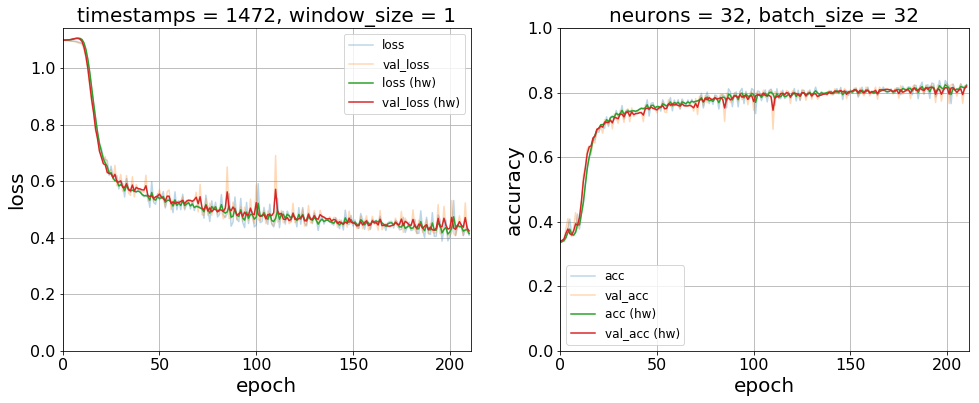

In [31]:
df_stats = pd.read_csv(msig.training_stats_filename)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# span = 111//30 = 3
span = epochs // 30

# ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=2, rowspan=3)
# ax2 = plt.subplot2grid((5, 4), (0, 2), colspan=2, rowspan=3)
# ax3 = plt.subplot2grid((5, 4), (3, 0), colspan=4, rowspan=2)

loss_dict = {
    'loss': df_stats.loss,
    'val_loss': df_stats.val_loss,
    'loss (hw)': reversed_recombined_holt_winters(np.array(df_stats.loss), span=span),
    'val_loss (hw)': reversed_recombined_holt_winters(np.array(df_stats.val_loss), span=span)

}
alphas = {
    'loss': 0.3,
    'val_loss': 0.3,
    'loss (hw)': 1,
    'val_loss (hw)': 1
}

legend_labels = []
for key, value in loss_dict.items():
    ax1.plot(value, alpha=alphas[key])
    legend_labels.append(key)

ax1.set_title(r'timestamps = {}, window_size = {}'.format(msig.n_timestamps, msig.window_size))
ax1.set_xlabel(r'epoch')
ax1.set_xlim((0, len(df_stats.acc)))
ax1.set_ylabel(r'loss')
ax1.set_ylim((0, None))
ax1.grid(True)
ax1.legend(legend_labels)

acc_dict = {
    'acc': df_stats.acc,
    'val_acc': df_stats.val_acc,
    'acc (hw)': reversed_recombined_holt_winters(np.array(df_stats.acc), span=span),
    'val_acc (hw)': reversed_recombined_holt_winters(np.array(df_stats.val_acc), span=span)

}
alphas = {
    'acc': 0.3,
    'val_acc': 0.3,
    'acc (hw)': 1,
    'val_acc (hw)': 1
}

legend_labels = []
for key, value in acc_dict.items():
    ax2.plot(value, alpha=alphas[key])
    legend_labels.append(key)

ax2.set_title(r'neurons = {}, batch_size = {}'.format(n_neurons, batch_size))
ax2.set_xlabel(r'epoch')
ax2.set_xlim((0, len(df_stats.acc)))
ax2.set_ylabel(r'accuracy')
ax2.set_ylim((0, 1))
ax2.grid(True)
ax2.legend(legend_labels)

plt.tight_layout()
plt.savefig(os.path.join(msig.out_dir, 'loss_accuracy.png'))
plt.show()

In [ ]:
# x_test, y_test = msig.generate()
# epoch = 0
# score = model.evaluate(x_test, y_test, batch_size=batch_size)
# if stateful:
#     model.reset_states()
# y_hat = model.predict(x_test, batch_size=batch_size)
# if stateful:
#     model.reset_states()
ii = 100
x_test = test_dict['X']
y_test = test_dict['y']
score = test_dict['score'][ii]
epoch = test_dict['epoch'][ii]
y_hat = test_dict['y_hat'][ii]
x_test_clipped = x_test[:, test_dict['window_size'] - 1:, 0]
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(y_hat, axis=-1)

# print('x_test  {}'.format(x_test.shape))
print('y_test  {}'.format(y_test.shape))
print('y_true  {}'.format(y_true.shape))
print(score)
print('y_hat   {}'.format(y_hat.shape))
print('y_pred  {}'.format(y_pred.shape))

if msig.window_type == 'boxcar' and msig.network_type == 'RNN':
    x_test_x_scatter = msig.timestamps
    x_test_y_scatter = msig.mixed_signal
    x_windows_start = np.reshape(msig.timestamps, y_pred.shape)[:, 0]
    y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])
elif msig.window_type == 'boxcar' and msig.network_type == 'MLP' and msig.sequence_type == 'many2many':
    x_test_x_scatter = msig.timestamps
    x_test_y_scatter = msig.mixed_signal
    x_windows_start = np.reshape(msig.timestamps, y_pred.shape)[:, 0]
    y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])
elif msig.window_type == 'sliding':
    x_test_x_scatter = msig.timestamps[msig.window_size-1:]
    x_test_y_scatter = msig.mixed_signal[msig.window_size-1:]
    x_windows_start = None
    if msig.sequence_type == 'many2many':
        y_true_colors = [msig.waves[i[-1]].color for i in y_true]
        y_pred_colors = [msig.waves[i[-1]].color for i in y_pred]
    else:
        y_true_colors = np.hstack([msig.waves[i].color for i in y_true])
        y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])

# print('y_colors{}'.format(y_pred_colors.shape))
# print(msig.timestamps.shape)
# print(x_test_x_scatter.shape)
# print(x_test_y_scatter.shape)
# print(x_windows_start)

# I derived y_score based on my intuition (i.e. out of thin air).  Would be nice to find some theoretical justification for why this is I like it so much.
if msig.sequence_type == 'many2many':
    y_true_value = [y_hat[i, j, y_true[i, j]] for i in range(y_true.shape[0]) for j in range(y_true.shape[1])]
    y_pred_value = [y_hat[i, j, y_pred[i, j]] for i in range(y_pred.shape[0]) for j in range(y_pred.shape[1])]
    y_true_value = np.reshape(y_true_value, y_true.shape)
    y_pred_value = np.reshape(y_pred_value, y_pred.shape)
    y_penalty = y_true_value - y_pred_value
    y_score = y_true_value + y_penalty
else:
    y_true_value = y_hat[(np.arange(y_true.shape[0]), y_true)]
    y_pred_value = y_hat[(np.arange(y_pred.shape[0]), y_pred)]
    y_penalty = y_true_value - y_pred_value
    y_score = y_true_value + y_penalty
    # Hack: Make y_score the same shape as many2many y_score
    y_score = y_score[:, None] * np.ones((msig.window_size,))[None, :]
    
print(y_true_value.shape)
print(y_pred_value.shape)
print(y_penalty.shape)
print(y_score.shape)

In [ ]:
print(y_true_colors[:4])
print(test_dict['class_colors'][y_true][:4])
test_dict['sequence_type']

In [ ]:
print(y_hat[:4])
print(y_true[:4])
print(y_true_value[:4])
print(y_hat[(np.arange(y_true.shape[0]), y_true)][:4])
print(y_pred_value[:4])
print(y_hat[(np.arange(y_pred.shape[0]), y_pred)][:4])
print(y_penalty)
print(y_score)

In [ ]:
# j = 10
# s0 = slice(0, j)
# s1 = slice(-j, -1)
# s0 = s1
# print(y_hat[s0, s1])
# print(y_true[s0, s1])
# print(y_true_value[s0, s1])
# print(y_pred[s0, s1])
# print(y_pred_value[s0, s1])
# print(y_penalty[s0, s1])
# print(y_score[s0, s1])
# print(np.min(y_score), np.max(y_score))

if msig.sequence_type == 'many2many':
    y_score_mean = y_score.sum(axis=1) / y_score.shape[1]
    y_score_unshifted = np.zeros((msig.n_timestamps, msig.window_size))
    for i in range(msig.window_size):
        y_score_unshifted[i:i + msig.n_samples, i] = y_score[:, i]
    y_score_unshifted_clipped = y_score_unshifted[msig.window_size-1:]
    y_score_unshifted_clipped_mean = y_score_unshifted_clipped.sum(axis=1) / y_score.shape[1]
else:
    
    y_score_mean = y_score.sum(axis=1) / y_score.shape[1]
    y_score_unshifted = np.zeros((msig.n_timestamps, msig.window_size))
    for i in range(msig.window_size):
        y_score_unshifted[i:i + msig.n_samples, i] = y_score[:, i]
    y_score_unshifted_clipped = y_score_unshifted[msig.window_size-1:]
    y_score_unshifted_clipped_mean = y_score_unshifted_clipped.sum(axis=1) / y_score.shape[1]
    

In [ ]:
xmin = 0
xmax = y_score.shape[0]
xindex = range(xmin, xmax)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)

ax[0].scatter(
    xindex, 
    x_test_clipped, 
    marker='.', 
    c=y_true_colors)
ax[0].set_title('epoch = {}'.format(epoch))
ax[0].set_xlim((xmin, xmax))
ax[0].set_xticks([])
ax[0].grid(True)

ax[1].imshow(
    y_score.T, 
    interpolation='nearest', 
    cmap=plt.get_cmap('Spectral'), 
    origin='upper');
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim((xmin, xmax))
ax[1].set_xticks([])
ax[1].set_ylim((y_score.shape[1], 0))
ax[1].set_yticks([y_score.shape[1]])

divider = make_axes_locatable(ax[1])
ax1Top = divider.append_axes("top", 0.5, sharex=ax[1])
ax1Top.xaxis.set_tick_params(labelbottom=False)
ax1Top.plot(y_score_mean)
ax1Top.set_title('sequence model type = {}'.format(msig.sequence_type))
ax1Top.set_xlim((xmin, xmax))
ax1Top.set_ylim((-1, 1))
ax1Top.set_yticks((-1, 0, 1))
ax1Top.grid(True)
# ax1Top.spines['bottom'].set_visible(False)

ax[2].imshow(
    y_score_unshifted_clipped.T, 
    interpolation='nearest', 
    cmap=plt.get_cmap('Spectral'), 
    origin='upper');
ax[2].spines['top'].set_visible(False)
ax[2].set_xlim((xmin, xmax))
ax[2].set_xticks([])
ax[2].set_ylim((y_score_unshifted_clipped.shape[1], 0))
ax[2].set_yticks([y_score_unshifted_clipped.shape[1]])

divider = make_axes_locatable(ax[2])
ax2Top = divider.append_axes("top", 0.5, sharex=ax[2])
ax2Top.xaxis.set_tick_params(labelbottom=False)
ax2Top.plot(y_score_unshifted_clipped_mean)
ax2Top.set_title('{} window size = {}'.format(window_type, msig.window_size))
ax2Top.set_xlim((xmin, xmax))
ax2Top.set_ylim((-1, 1))
ax2Top.set_yticks((-1, 0, 1))
ax2Top.grid(True)
# ax2Top.spines['bottom'].set_visible(False)

ax[3].scatter(
    xindex, 
    x_test_clipped,
    marker='.', 
    c=y_pred_colors)
ax[3].set_title('loss = {:<6.4f}, accuracy = {:<.2%}'.format(*score))
ax[3].set_xlim((xmin, xmax))
ax[3].grid(True)

# plt.draw()
plt.savefig(os.path.join(msig.out_dir, 'prediction_analysis.png'), bbox_inches='tight', pad_inches=0.08)
# plt.show()

In [ ]:
if sequence_type == 'many2many':
    plot_confusion_matrix(y_true[:, -1], y_pred[:, -1], figsize=(8, 6), filename=os.path.join(msig.out_dir, 'confusion_matrix.png'))
else:
    plot_confusion_matrix(y_true, y_pred, figsize=(8, 6), filename=os.path.join(msig.out_dir, 'confusion_matrix.png'))

In [ ]:
import importlib

In [ ]:
importlib.reload(plot_utils);

In [ ]:
import mixsig.plot_utils as plot_utils

In [ ]:
plot_utils.plot_prediction_tests(test_dict, os.path.join(msig.out_dir, 'training_snapshots'))

Now browse to the training_snapshots folder and run,
```bash
ffmpeg -framerate 30 -i %05d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ../prediction_analysis.mp4
```

In [20]:
from mixsig.utils import factors
# TODO: Move this to unit tests
ws, bs = 512, 392
nts = 200771
print(f'nts   = {nts}\nws*bs = {ws * bs}')
print(factors(nts))

fact_a = factors(bs)
print(fact_a)
fact_b = factors(ws)
print(fact_b)
gcm = max(fact_a.intersection(fact_b))
print(gcm)

print('#'*20)
print(ws * bs // gcm)
print(nts % (ws * bs // gcm))
nts2 = nts - (nts % (ws * bs // gcm))
print(nts2, nts2 // bs, nts2 // ws)

print('#'*20)
print(ws * bs)
print(nts % (ws * bs))
nts2 = nts - (nts % (ws * bs))
print(nts2, nts2 // bs, nts2 // ws)

nts   = 200771
ws*bs = 200704
{1, 200771}
{1, 2, 98, 196, 4, 7, 392, 8, 14, 49, 56, 28}
{512, 1, 2, 256, 4, 128, 64, 32, 8, 16}
8
####################
25088
67
200704 512 392
####################
200704
67
200704 512 392


In [ ]:
fig = plt.figure(figsize=(5,3))
plt.plot(y_score.sum(axis=0) / y_score.shape[0])
plt.xlim((0, y_score.shape[1]))
plt.xlabel('timestep')
plt.ylim((0, 1))
plt.ylabel('classifier score')
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mean_accuracy_vs_timestep.png'))

## current validation signal

In [ ]:
print(x_val.shape)
print(hidden_layers['1'].shape)
print(output_layers.shape)
print(y_val.shape)

In [ ]:
print(x_val.shape)
print(hidden_layers['1']['output'].shape)
print(hidden_layers['1']['state'].shape)
print(z1_layers.shape)
print(output_layers.shape)
print(y_val.shape)

In [ ]:
arr = np.reshape(z2_layers[..., 5], (1000, 1000))
fig = plt.figure(figsize=(14, 8))

ax = plt.subplot(111)
im = ax.imshow(arr, interpolation="none")

plt.tight_layout()
# plt.savefig(os.path.join(msig.out_dir, 'gen_loss_acc.png'))
# plt.show()

In [ ]:
layer = '1'
o_or_s = 'output'
val_arrays = np.load(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s])) + '.npy')
print(val_arrays.shape)
glance_at_tensor(val_arrays)

In [ ]:
out_dir = '/home/maddoxw/PycharmProjects/MixSig/out/2018-04-09_04-53-12'

In [ ]:
val_arrays = np.load(os.path.join(vsig.out_dir, 'valid_output_layer.npy'))
print(val_arrays.shape)
glance_at_tensor(val_arrays)

In [ ]:
score = model.evaluate(x_val, y_val, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_val, batch_size=batch_size)
model.reset_states()

In [ ]:
# y_pred = np.argmax(states['y_hat'], axis=1)
# y_pred_colors = np.hstack([vsig.signal_colors[i] for i in y_pred])

layer = '1'
val_arrays = np.load(os.path.join(vsig.out_dir, 'valid_hidden_layer_' + layer + '_output.npy'))
n_generations, _, n_neurons = val_arrays.shape
ncols = 1
nrows = n_neurons // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for g in range(n_generations):
    for i in range(n_neurons):
        ax = axes#[i // ncols, i % ncols]
        ax.cla()
        y_pred_colors = val_arrays[g, :, i]
        ax.plot(vsig.timestamps, vsig.mixed_signal, color='grey', alpha=0.3)
        ax.scatter(
            vsig.timestamps[vsig.window_size-1:], 
#             vsig.timestamps, 
#             x_val[:, -1, 0], 
#             x_val[0, :, 0], 
            vsig.mixed_signal[vsig.window_size-1:], 
            marker='o', 
            c=y_pred_colors, 
            cmap=plt.get_cmap('coolwarm'), 
            vmin=-1, 
            vmax=1
        )
        ax.set_title('neuron = {}'.format(i + 1))
        ax.set_xlim((vsig.t_min, vsig.t_max))
        ax.grid(True)
        
    plt.tight_layout()
    plt.suptitle('hidden layer = {}, ({}), generation = {}'.format(layer, 'output', g + 1))
#     plt.savefig(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, 'gen', str(g + 1)]) + '.png'))

plt.show()

In [ ]:
# y_pred = np.argmax(states['y_hat'], axis=1)
# y_pred_colors = np.hstack([vsig.signal_colors[i] for i in y_pred])

layer = '2'
o_or_s = 'output'
val_arrays = np.load(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s])) + '.npy')
n_generations, _, n_neurons = val_arrays.shape
ncols = 2
nrows = n_neurons // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))

for g in range(n_generations):
    for i in range(n_neurons):
        ax = axes[i // ncols, i % ncols]
        ax.cla()
        y_pred_colors = val_arrays[g, :, i]
        ax.plot(vsig.timestamps, vsig.mixed_signal, color='grey', alpha=0.3)
        ax.scatter(
#             vsig.timestamps[vsig.window_size-1:], 
            vsig.timestamps, 
#             x_val[:, -1, 0], 
            x_val[0, :, 0], 
            vsig.timestamps[vsig.window_size-1:], 
            marker='o', 
            c=y_pred_colors, 
            cmap=plt.get_cmap('coolwarm'), 
            vmin=-1, 
            vmax=1
        )
        ax.set_title('neuron = {}'.format(i + 1))
        ax.set_xlim((vsig.t_min, vsig.t_max))
        ax.grid(True)
        
    plt.tight_layout()
    plt.suptitle('hidden layer = {}, ({}), generation = {}'.format(layer, o_or_s, g + 1))
    plt.savefig(os.path.join(vsig.out_dir, '_'.join(['valid_hidden_layer', layer, o_or_s, 'gen', str(g + 1)]) + '.png'))

plt.show()

In [ ]:
x_test, y_test = msig.generate()
y_hat, *args = model2.predict(x_test, batch_size=batch_size)
model2.reset_states()
y_pred = np.argmax(y_hat, axis=-1)
print('x_test', x_test.shape, '{:>9.4f} {:>9.4f}'.format(np.min(x_test), np.max(x_test)))
print('y_test', y_test.shape)
print('y_hat ', y_hat.shape, '{:>9.4f} {:>9.4f}'.format(np.min(y_hat), np.max(y_hat)))
print('y_pred', y_pred.shape, '{} {}'.format(np.min(y_pred), np.max(y_pred)))
for i, arg in enumerate(args):
    print(i, arg.shape, '{:>9.4f} {:>9.4f}'.format(np.min(arg), np.max(arg)))

In [ ]:
y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])
print(y_pred_colors[:3])
print(y_pred.shape, y_pred_colors.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
# ax.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
# ax.scatter(msig.timestamps, x_test[0, :, 0], marker='.', c=y_pred_colors)
ax.scatter(msig.timestamps[msig.window_size-1:], msig.mixed_signal[msig.window_size-1:], marker='.', c=y_pred_colors)
ax.set_xlabel('time')
ax.set_xlim((msig.t_min, msig.t_max))
plt.grid(True)
plt.show()

In [ ]:
x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
y_hat = model.predict(x_test, batch_size=batch_size)
model.reset_states()
y_pred = np.argmax(y_hat, axis=1)
# y_pred_colors = [msig.waves[i].color for i in msig.labels[msig.window_size-1:]]
y_pred_colors = np.hstack([msig.waves[i].color for i in y_pred])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
ax.set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax.set_xlabel('time')
ax.set_xlim((msig.t_min, msig.t_max))
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'eval_pred.png'))
plt.show()

In [ ]:
x_test, y_test = msig.generate()
print(x_test.shape)
print(y_test.shape)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
print(score)

y_hat = model.predict(x_test, batch_size=batch_size)
y_pred = np.argmax(y_hat, axis=1)
# y_error = 1.0 - np.max(y_hat, axis=1)
model.reset_states()
# print(y_hat.shape)
print(y_pred.shape)
# print(y_error.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax[0].scatter(msig.timestamps, msig.mixed_signal, marker='.')
ax[0].set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax[0].set_xlim((msig.t_min, msig.t_max))

ax[1].plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
ax[1].scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred)
ax[1].set_xlim((msig.t_min, msig.t_max))
ax[1].set_xlabel('time')
plt.show()

# Transfer weights to new model

In [ ]:
n_batch = 1
print(X.shape)
print(n_batch)
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
new_model.add(LSTM(n_neurons))
new_model.add(Dense(msig.n_classes, activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_test, y_test = msig.generate()
score = new_model.evaluate(x_test, y_test, batch_size=n_batch)
print(score)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [ ]:
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

In [ ]:
x_test, y_test = msig()
print(x_test.shape)
print(y_test.shape)
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.window_size-1:], x_test[:, -1, 0], marker='.', c=y_error)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[-msig.n_samples:], y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps[-msig.n_samples:], y_error, marker='.', c=y_error)
plt.show()

# TimeDistributed testing

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed

## One-to-One LSTM for Sequence Prediction

In [ ]:
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(length, 1, 1)
y = seq.reshape(length, 1)
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

In [ ]:
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)

In [ ]:
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
print(X.shape, result.shape)
# print(X)
# print(result)
for value in result:
    print('%.1f' % value)

## Many-to-One LSTM for Sequence Prediction (without TimeDistributed)

In [ ]:
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

In [ ]:
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)

In [ ]:
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
print(X.shape, result.shape)
print(X)
print(result)
for value in result[0,:]:
    print('%.1f' % value)

## Many-to-Many LSTM for Sequence Prediction (with TimeDistributed)

In [ ]:
# prepare sequence
length = 19
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = 5
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

## Many-to-Many LSTM for Sequence Prediction (without TimeDistributed)

In [ ]:
# prepare sequence
length = 19
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length, 1)
# define LSTM configuration
n_neurons = 5
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1), return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

In [ ]:
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=1)

In [ ]:
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
print(X.shape, result.shape)
for x, value in zip(X[0, :, 0], result[0, :, 0]):
    print('{:>.2f} {:>.3f}'.format(x, value))

In [ ]:
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=1)

In [ ]:
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
print(X.shape, result.shape)
for x, value in zip(X[0, :, 0], result[0, :, 0]):
    print('{:>.2f} {:>.3f}'.format(x, value))

In [ ]:
import pandas as pd

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

In [ ]:
batch_size = 1 # this example is too small to use anything larger than 1.
window_size = 7  # This is the size after unrolling.
n_features = 1  # Assume each red square represents a single number.
n_layers = 3  # These are the middle 3 horizontal layers.
n_neurons = 2  # One neuron for the green block(s) and one for the yellow.
n_outputs = 7  # because it's many to many.

seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)

x = Input(batch_shape=(batch_size, window_size, n_features))  # bottom row of red blocks.
h = LSTM(n_neurons, return_sequences=True)(x)  # hidden layer 1
h = LSTM(n_neurons, return_sequences=True)(h)  # hidden layer 2
h = LSTM(n_neurons, return_sequences=True)(h)  # hidden layer 3
z = TimeDistributed(Dense(n_outputs, activation='softmax'))(h)  # top row of blue blocks
model = Model(inputs=[x],outputs=[z])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

# Stateful Test 

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
    diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values[1:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# execute the experiment
def run():
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # experiment
    repeats = 10
    results = DataFrame()
    # run experiment
    results['results'] = experiment(repeats, series)
    # summarize results
    print(results.describe())
    # save results
    results.to_csv('experiment_stateful.csv', index=False)

 # entry point
run()

In [ ]:
# fit an LSTM network to training data. stateful=True, shuffle=False
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
# fit an LSTM network to training data. stateful=False, shuffle=False
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

In [ ]:
# fit an LSTM network to training data. stateful=False, shuffle=True
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=True)
    return model

In [ ]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful2.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

In [ ]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateless.csv', 'experiment_stateless_shuffle.csv']
results = DataFrame()
for name in filenames:
    results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()
